# 1. Choix du sujet

Nous souhaitions dès le départ travailler sur un projet graphique mêlant simulation et génération procédurale. En explorant les propositions, le [sujet 21](https://github.com/jsboigeEpita/2025-Epita-Programmation-par-Contraintes/tree/main?tab=readme-ov-file#21-g%C3%A9n%C3%A9ration-proc%C3%A9durale-de-niveaux-de-jeu-vid%C3%A9o-sous-contraintes)  nous a semblé intéressant comme point de départ, bien que nous ayons fini par en diverger.

Nous avons choisi de nous orienter vers la **génération de villes par contraintes**. L’objectif est de modéliser un terrain et d’y placer des bâtiments en respectant un ensemble de règles :

- un **réseau routier continu** doit être présent,
- les bâtiments ne peuvent être construits que :
  - sur des tuiles de **terre**,
  - et **adjacentes à une route**,
- chaque type de bâtiment possède ses propres contraintes spécifiques (détaillées plus loin).

La génération se fait en 2D, sur une grille de taille fixée, divisée en **tiles**. Chaque tile contient un unique type d’élément : **route**, **terre** ou **bâtiment**. De plus, chaque entité occupe exactement **une seule tile** (pas de bâtiments multi-tiles).


---

# 2. Mise en place

Nous avons opté pour une interface graphique web 2D afin de faciliter les tests et d’obtenir un retour visuel rapide.  
Pour cela, nous utilisons :
- **JavaScript** pour le rendu,
- la bibliothèque **Pixi.js** pour l'affichage 2D,
- et le module **`eel`** pour faire le lien entre le **backend Python** (résolution des contraintes) et le **frontend**.

Le projet complet peut être lancé avec la commande suivante :
```bash
python -m sims.main
```

Cependant, pour mieux illustrer notre démarche et notre progression, nous intégrerons directement des visuels et sorties dans ce notebook.

---

## 2.1 Fonctions utilitaires

On commence par importer les modules nécessaires.

In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
from IPython.display import display
from enum import Enum, IntEnum
from noise import pnoise2
import random
from ipywidgets import interact
from z3 import *

---

La cellule suivante est reponsable de l'affichage, il n'y a pas de logique intéressante dedans

In [2]:
# All the possible tiles
class Tile(IntEnum):
    NONE = 0
    ROAD = 1
    WATER = 2
    HOUSE = 3

# Graphical variants for each one
tileTexture = {
    0: ['none0', 'none1', 'none2', 'none2', 'none3', 'none4'],
    1: ['road'],
    2: ['water', 'water0', 'water1'],
    3: ['house']
}


# Load all tiles and their variants
TILE_IMAGES = {}
def load_images():
    image_folder = Path("sims/web/images")
    
    for tile_id, variants in tileTexture.items():
        TILE_IMAGES[tile_id] = []
        for variant in variants:
            img_path = image_folder / f"{variant}.png"
            if img_path.exists():
                TILE_IMAGES[tile_id].append(Image.open(img_path).convert("RGBA"))
            else:
                print(f"Warning: Missing image {img_path}")

# take a grid in parameter and display a canvas
def plot(grid):
    if len(TILE_IMAGES) == 0:
        load_images()

    tile_size = TILE_IMAGES[0][0].size
    canvas = Image.new("RGBA", (grid.shape[1] * tile_size[0], grid.shape[0] * tile_size[1]))

    for y in range(grid.shape[0]):
        for x in range(grid.shape[1]):
            tile_id = grid[y, x]
            variants = TILE_IMAGES.get(tile_id, [])
            if variants:
                tile_img = random.choice(variants)
                canvas.paste(tile_img, (x * tile_size[0], y * tile_size[1]), tile_img)

    display(canvas)

---

## 2.2 Variables globales

Ici sont exposé des variables globales permettant de modifier le comportement du système :

In [3]:
# Control the size of the grid (the number of tiles)
GRID_WIDTH = 50
GRID_HEIGHT = 30

---

## 2.3 Génération d'une grille vide

On commence par générer une grille vide de la bonne taille. Ce sera le support pour la suite du notebook

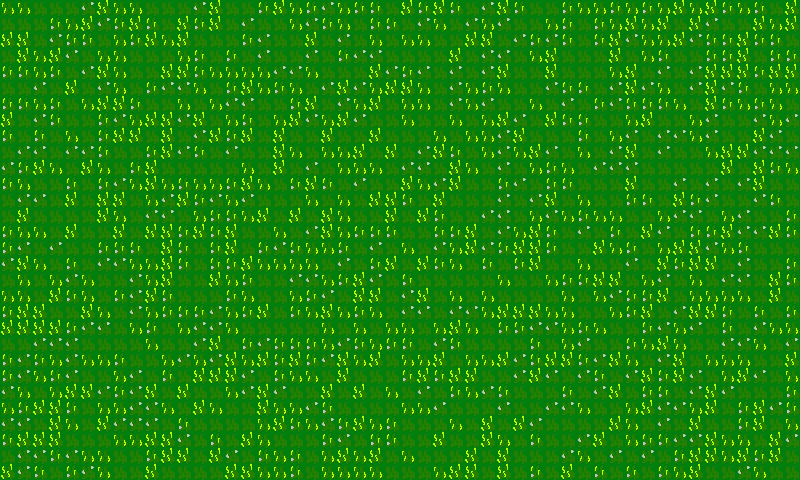

In [4]:
generated = np.array([[Tile.NONE for _ in range(GRID_WIDTH)] for _ in range(GRID_HEIGHT)])

plot(generated)

---

# 3. Génération

## 3.1 Génération du réseau routier

Après plusieurs essais et réflexions, nous avons opté pour une approche séquentielle consistant à générer d'abord le réseau de routes, puis à appliquer les autres contraintes par la suite. Cette stratégie s’est avérée plus simple et plus flexible que de tenter de tout modéliser simultanément. Notre choix repose sur plusieurs considérations :

- **Contrôle algorithmique** : Générer les routes en amont nous permettait de choisir et de paramétrer librement l’algorithme de génération, ce qui nous offrait un meilleur contrôle sur la structure du réseau.
- **Lisibilité et modularité** : Mélanger les contraintes dès le départ aurait considérablement complexifié le modèle, rendant le code plus difficile à maintenir et à ajuster.
- **Nature du problème** : La génération de routes repose sur des notions de connectivité globale qui sont complexes à exprimer en programmation par contrainte pure. Elle nécessite souvent des bibliothèques spécialisées qui sortent du cadre de notre projet. Pour des raisons de temps et de clarté, nous avons donc choisi de traiter cette partie séparément.

---

### Génération avec Z3

Bien que Z3 ne soit pas idéalement adapté à ce type de contrainte, nous avons souhaité tester son utilisation, à la fois pour valider la faisabilité de cette approche et pour nous familiariser davantage avec l'outil.

La cellule suivante illustre notre logique de génération, avec un curseur permettant de contrôler dynamiquement le nombre maximal de routes.

In [5]:
@interact(max_count=(0,2000))
def generate_road_z3(max_count=700):
    grid = [[Bool(f"r_{y}_{x}") for x in range(GRID_WIDTH)] for y in range(GRID_HEIGHT)]
    
    s = Solver()
    
    s.add(Sum([If(cell, 1, 0) for row in grid for cell in row]) <= max_count)
    
    # Each road must at least be near 2 other roads
    for y in range(GRID_HEIGHT):
        for x in range(GRID_WIDTH):
            neighbors = []
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < GRID_HEIGHT and 0 <= nx < GRID_WIDTH:
                    neighbors.append(grid[ny][nx])
            if neighbors:
                s.add(Implies(grid[y][x], Sum([If(n, 1, 0) for n in neighbors]) >= 2))

    # Prevent from having clusters of 2x2 of only roads
    for y in range(GRID_HEIGHT - 1):
        for x in range(GRID_WIDTH - 1):
            square = [
                grid[y][x],
                grid[y][x+1],
                grid[y+1][x],
                grid[y+1][x+1]
            ]
            s.add(Sum([If(c, 1, 0) for c in square]) <= 3)

    # Plotting part
    if s.check() == sat:
        m = s.model()
        road_grid = np.array(generated)
        for y in range(GRID_HEIGHT):
            for x in range(GRID_WIDTH):
                road_grid[y, x] = 1 if m.evaluate(grid[y][x]) else 0
    
        plot(road_grid)
    else:
        print("Pas de solution.")

interactive(children=(IntSlider(value=700, description='max_count', max=2000), Output()), _dom_classes=('widge…

---

Cependant, nous nous sommes rapidement aperçus que cette méthode de génération présentait plusieurs limites importantes :

- Elle offre très peu de contrôle sur le nombre exact de routes, et ne comporte aucun élément aléatoire.
- Son temps d'exécution est relativement long, malgré une taille de grille modeste.
- Le réseau généré n’est pas toujours connecté de manière cohérente.

Un des rares avantages de cette approche réside dans la présence de motifs singuliers intéressants (bien que parfois trop répétitifs).

En particulier à cause des deux derniers points, nous avons décidé d'explorer d'autres solutions pour la génération du réseau routier. Afin de ne pas alourdir inutilement ce notebook, nous n’y avons conservé que les idées principales, les algorithmes testés, une synthèse des résultats obtenus, et enfin la méthode retenue.

---

### Distance entre centroïdes

Nous avons commencé par réfléchir en termes de destinations : un réseau de routes est avant tout créé pour relier des points entre eux. Ainsi, nous avons envisagé un algorithme fondé sur la notion de centroïdes :

1. Diviser la grille en cellules régulières.
2. Dans chaque cellule, définir un centroïde (au centre et très légèrement décalé aléatoirement).
3. Répéter *n* fois :
    - Sélectionner deux centroïdes au hasard.
    - Tracer une route entre eux en suivant un trajet basé sur la distance de Manhattan.

Cette approche a finalement été écartée pour plusieurs raisons :

- Les routes n’étaient pas toujours continues.
- Le résultat était visuellement désordonné et peu cohérent.
- Elle entraînait parfois la création d’amas de routes (ex. : des blocs de 3x3 cases composés uniquement de routes).

---

### Construction multi-agents

Après réflexion, nous avons envisagé une approche inspirée des systèmes multi-agents, en simulant un comportement proche de celui de fourmis explorant un territoire. Les chemins parcourus par ces agents deviennent alors nos routes.

L'algorithme proposé repose sur les étapes suivantes :

1. Générer un agent à un point de départ.
2. Répéter *n* fois pour chaque agent, en introduisant une part d’aléatoire (avec pondérations sur les choix possibles) :
    - Avancer et placer une route, uniquement si moins de trois routes sont présentes autour de la case.
    - Tourner dans une direction (par pas de 90°).
    - Émettre un nouvel agent ("enfant").
    - Mourir.

Malheureusement, cette méthode produit des motifs trop chaotiques et rend difficile le contrôle du comportement global du système, notamment à cause du caractère hautement aléatoire de l'exploration.

---

### Génération par "mur de labyrinthe"

Nous avons finalement exploré une approche fondée sur la génération de labyrinthe, en utilisant un algorithme de backtracking (DFS). L'idée est de construire un labyrinthe classique, puis de ne conserver que les "murs" pour en faire notre réseau de routes. Cette méthode a plusieurs avantages :

- Tous les murs (donc routes) sont connectés, ce qui garantit la continuité du réseau.
- Le motif obtenu est structuré tout en restant suffisamment complexe pour être intéressant.

Dans la cellule suivante, vous pouvez visualiser le résultat de cette méthode, avec un curseur permettant d'ajuster les paramètres de génération.

In [6]:
DIRS = [(0, 2), (2, 0), (0, -2), (-2, 0)]

def generate_labyrinth_roads(grid: list[list[int]]) -> list[list[int]]: 
    grid_width, grid_height = GRID_WIDTH, GRID_HEIGHT

    start_x, start_y = 1, 1
    while grid[start_y][start_x] == Tile.WATER:
        start_x = random.randint(1, grid_width - 1)
        start_y = random.randint(1, grid_height - 1)
    grid[start_y][start_x] = Tile.ROAD
    walls = [(start_x + dx, start_y + dy) for dx, dy in DIRS]
    
    while walls:
        wx, wy = random.choice(walls)
        walls.remove((wx, wy))

        if 0 < wx < grid_width-1 and 0 < wy < grid_height-1:
            neighbors = []
            if wx >= 2 and grid[wy][wx - 2] == Tile.ROAD:
                neighbors.append((wx - 2, wy))
            if wx < grid_width - 2 and grid[wy][wx + 2] == Tile.ROAD:
                neighbors.append((wx + 2, wy))
            if wy >= 2 and grid[wy - 2][wx] == Tile.ROAD:
                neighbors.append((wx, wy - 2))
            if wy < grid_height - 2 and grid[wy + 2][wx] == Tile.ROAD:
                neighbors.append((wx, wy + 2))

            if len(neighbors) == 1:
                nx, ny = neighbors[0]
                midY = (wy + ny)//2
                midX = (wx + nx)//2

                grid[wy][wx] = Tile.ROAD
                grid[midY][midX] = Tile.ROAD

                for dx, dy in DIRS:
                    new_wx, new_wy = wx + dx, wy + dy
                    if 0 <= new_wx < grid_width and 0 <= new_wy < grid_height:
                        if grid[new_wy][new_wx] != Tile.ROAD:
                            walls.append((new_wx, new_wy))

    return grid

@interact(seed=(0, 1000))
def plot_road(seed=0):
    road = generate_labyrinth_roads(np.array(generated))

    plot(road)

interactive(children=(IntSlider(value=0, description='seed', max=1000), Output()), _dom_classes=('widget-inter…

---

## 3.1 Génération de rivières

Nous avons constaté qu'un réseau composé uniquement de routes générées de manière procédurale manquait de variété et de complexité. Bien que le réseau soit aléatoire, cette approche produisait des structures similaires à chaque exécution, ce qui rendait les résultats peu intéressants. Afin d'introduire de la diversité et de la difficulté dans le modèle, nous avons décidé d'ajouter des rivières et des lacs de manière aléatoire.

Plusieurs algorithmes ont été testés pour la génération des rivières :

- **Choix de points aléatoires et rayon autour de chaque point** : Cette méthode consistait à sélectionner plusieurs points aléatoires sur la carte et à définir un rayon autour de chaque point comme étant des zones d'eau. Cependant, le résultat était trop pixelisé et visuellement peu attrayant.
- **Bruit de Perlin simple** : Bien que cette technique génère des motifs fluides et naturels, les grands motifs créés manquaient de variété et remplissaient excessivement la carte.
- **Ridge noise avec peu d'octaves** : Cette approche a permis de créer un réseau de rivières plus intéressant, offrant une structure à la fois aléatoire et cohérente. En combinant une graine aléatoire et un léger offset, nous avons pu générer des rivières réalistes tout en conservant un aspect aléatoire et fluide.

Nous avons également envisagé l'ajout de forêts et de déserts, mais nous avons choisi de nous concentrer sur les rivières pour le moment. En effet, l'intégration de trop de biomes pourrait restreindre l'espace libre disponible, notamment avec les nombreuses autres contraintes déjà en place dans le modèle.

La cellule suivante illustre l'utilisation du Ridge Noise, l'algorithme retenu pour cette génération. Des paramètres sont également présents pour tester le comportement de l'algorithme avec différentes configurations.



In [7]:
TRESH = 0.97
SCALE = 50

def generate_river(x=0, y=0, seed=0, persistence=0.5, lacunarity=2):
    grid = np.array(generated)
    grid_width, grid_height = GRID_WIDTH, GRID_HEIGHT
    
    # Génération du bruit Perlin et transformation en ridge noise
    for i in range(grid_height):
        for j in range(grid_width):
            # Génération du bruit Perlin
            noise_value = pnoise2(y + i / SCALE, x + j / SCALE, octaves=2, persistence=persistence, lacunarity=lacunarity, base=seed)
            # Application du ridge noise (inverser la valeur absolue)
            ridge = 1 - abs(noise_value)

            if ridge > TRESH and grid[i,j] == Tile.NONE:
                grid[i,j] = Tile.WATER
    
    return grid

@interact(x=(0, 10, 0.1), y=(0, 10, 0.1), seed=(0, 1000), persistence=(0, 1, 0.01), lacunarity=(0, 4, 0.1))
def plot_generate_river(x, y, seed, persistence=0.5, lacunarity=2):    
    plot(generate_river(x, y, seed, persistence, lacunarity))

interactive(children=(FloatSlider(value=5.0, description='x', max=10.0), FloatSlider(value=5.0, description='y…

---

## Intégration du réseau routier avec les rivières

Le problème rencontré à cette étape était de réussir à combiner le réseau routier avec les rivières.

Il fallait en effet s'assurer que :
- chaque îlot possède ses propres routes internes,
- tous les îlots soient reliés entre eux, malgré la présence des rivières.

C’est dans ce contexte que nous avons découvert le [problème des points les plus proches](https://en.wikipedia.org/wiki/Closest_pair_of_points_problem).  
Dans notre cas, nous avons implémenté un algorithme naïf, car le nombre de routes restait relativement limité.

Nous avions également envisagé de ne prendre en compte que les routes proches de l’eau (touchant directement une rivière ou situées à une case de distance).  
Cependant, cela posait problème : certaines générations produisaient des routes qui traversaient entièrement la carte, créant un réseau peu cohérent ou inefficace.

Dans la cellule suivante, nous présentons l’algorithme utilisé pour fusionner les deux réseaux.



In [8]:
DIRS = [(0, 2), (2, 0), (0, -2), (-2, 0)]
DIRS1 = [(0, 1), (1, 0), (0, -1), (-1, 0)]

def flood_fill(grid, flooded, x_start, y_start, i):
    toVisit = [(x_start,y_start)]
    while toVisit:
        x,y = toVisit.pop()

        if flooded[y][x] == i or grid[y][x] == Tile.WATER:
            continue

        flooded[y][x] = i

        for dx, dy in DIRS1:
            xx = x + dx
            yy = y + dy

            if xx < 0 or yy < 0 or xx >= GRID_WIDTH or yy >= GRID_HEIGHT:
                continue

            toVisit.append((xx,yy))

def is_near_water(grid, x, y):
    for dx, dy in DIRS:
        xx = x + dx
        yy = y + dy

        if xx < 0 or yy < 0 or xx >= GRID_WIDTH or yy >= GRID_HEIGHT:
            continue

        if grid[yy, xx] == Tile.WATER:
            return True

    return False

def generate_labyrinth_roads(grid, start_x, start_y): 
    grid_width, grid_height = GRID_WIDTH, GRID_HEIGHT

    grid[start_y][start_x] = Tile.ROAD
    walls = [(start_x + dx, start_y + dy) for dx, dy in DIRS]
    near_water = set()
    
    while walls:
        wx, wy = random.choice(walls)
        walls.remove((wx, wy))

        if 0 < wx < grid_width-1 and 0 < wy < grid_height-1 and grid[wy][wx] == Tile.NONE:
            neighbors = []
            if wx >= 2 and grid[wy][wx - 2] == Tile.ROAD:
                neighbors.append((wx - 2, wy))
            if wx < grid_width - 2 and grid[wy][wx + 2] == Tile.ROAD:
                neighbors.append((wx + 2, wy))
            if wy >= 2 and grid[wy - 2][wx] == Tile.ROAD:
                neighbors.append((wx, wy - 2))
            if wy < grid_height - 2 and grid[wy + 2][wx] == Tile.ROAD:
                neighbors.append((wx, wy + 2))

            if len(neighbors) == 1:
                nx, ny = neighbors[0]
                if grid[ny][nx] == Tile.WATER:
                    continue
                midY = (wy + ny)//2
                midX = (wx + nx)//2

                if grid[midY][midX] != Tile.NONE:
                    continue

                grid[wy][wx] = Tile.ROAD
                grid[midY][midX] = Tile.ROAD

                near_water.add((wx, wy))
                near_water.add((midX, midY))

                for dx, dy in DIRS:
                    new_wx, new_wy = wx + dx, wy + dy
                    if 0 <= new_wx < grid_width and 0 <= new_wy < grid_height:
                        if grid[new_wy][new_wx] == Tile.NONE:
                            walls.append((new_wx, new_wy))

    return grid, near_water

def generate_road(grid):
    flooded = np.zeros_like(grid)
    set_i = 1
    prev_road = []

    for x in range(0, GRID_WIDTH):
        for y in range(0, GRID_HEIGHT):
            if grid[y, x] == Tile.WATER:
                continue

            if flooded[y, x] > 0:
                continue

            if is_near_water(grid, x, y):
                continue

            grid, near_water = generate_labyrinth_roads(grid, x, y)

            flood_fill(grid, flooded, x, y, set_i)
            set_i += 1

            prev_road.append(np.array(list(near_water)))
                             
    for i in range(1, len(prev_road)):
        A, B = prev_road[i - 1], prev_road[i]

        dists = np.linalg.norm(A[:, None] - B[None, :], axis=2)
        i, j = np.unravel_index(np.argmin(dists), dists.shape)
        
        sx, sy = A[i]
        ex, ey = B[j]
        
        # Convert to integers (after swapping if needed)        
        sx, sy, ex, ey = map(int, (sx, sy, ex, ey))

        dx = 1 if sx < ex else -1
        dy = 1 if sy < ey else -1

        while sx != ex:
            grid[sy][sx] = Tile.ROAD
            sx += dx

        while sy != ey:
            grid[sy][sx] = Tile.ROAD
            sy += dy

    return grid

@interact(seed=(0, 1000))
def plot_road(seed=0):
    rivers = generate_river(seed=seed)
    road = generate_road(rivers)

    plot(road)

interactive(children=(IntSlider(value=0, description='seed', max=1000), Output()), _dom_classes=('widget-inter…

---

# 4. Contraintes

## Contraintes simples

Voici un récapitulatif de notre premier jeu de contraintes :

- Les bâtiments ne peuvent être placés que sur de la terre ferme (pas sur l'eau, ni sur une autre structure).
- Chaque bâtiment doit être adjacent à une route (au moins un de ses côtés doit toucher directement une case de route).
- La ville doit accueillir une population totale de $n_{hab}$ habitants.
- Chaque habitation peut contenir jusqu’à $m$ habitants.

Nous avons exploré plusieurs algorithmes pour répondre à ces contraintes, détaillés dans les sections suivantes.

---

## Contraintes avancées

Nous avons identifié deux formes générales de contraintes spatiales pouvant être appliquées à différents types de bâtiments :

### 1. Contraintes de voisinage dans un rayon donné
Il doit exister un nombre de bâtiments d’un certain type (`selector`) compris entre $X_{\min}$ et $X_{\max}$ dans un voisinage défini par un rayon minimal $r_{\min}$ et un rayon maximal $r_{\max}$ autour de la case considérée.

Formellement, pour une case $c$, on impose :
$$
X_{\min} \leq \sum_{c' \in \mathcal{N}(c, r_{\min}, r_{\max})} \mathbb{1}_{\text{type}(c') = \text{selector}} \leq X_{\max}
$$
où $\mathcal{N}(c, r_{\min}, r_{\max})$ est l'ensemble des cases $c'$ situées à une distance $d$ telle que $r_{\min} \leq d(c, c') \leq r_{\max}$.

### 2. Contraintes sur ligne et colonne
Il doit y avoir entre $X_{\min}$ et $X_{\max}$ bâtiments d’un certain type sur **la même ligne** et/ou **la même colonne** qu’une case donnée.

Formellement, pour une case $c$, on impose :
$$
X_{\min} \leq \sum_{c' \in \mathcal{L}(c)} \mathbb{1}_{\text{type}(c') = \text{selector}} + \sum_{c' \in \mathcal{C}(c)} \mathbb{1}_{\text{type}(c') = \text{selector}} \leq X_{\max}
$$
où $\mathcal{L}(c)$ est l’ensemble des cases sur la même ligne que $c$, et $\mathcal{C}(c)$ celles sur la même colonne.

---

### Exemples de bâtiments spécifiques

- **Port** :
  - Doit être construit **sur une case d'eau**.
  - Doit être **adjacent à une route** (au moins une case voisine de type route).

- **Antenne** :
  - Ne doit avoir **aucun bâtiment** dans un rayon de 3 cases.
  
  $$ 
  \sum_{c' \in \mathcal{N}(c, 1, 3)} \mathbb{1}_{\text{type}(c') \in \text{Bâtiments}} = 0 
  $$

- **Supermarché** :
  - Doit avoir **au moins 3 maisons** situées sur **la même ligne ou colonne**, dans un rayon de 3 cases maximum.

  $$
  \sum_{c' \in \mathcal{L}_3(c) \cup \mathcal{C}_3(c)} \mathbb{1}_{\text{type}(c') = \text{Maison}} \geq 3
  $$
  où $\mathcal{L}_3(c)$ (resp. $\mathcal{C}_3(c)$) représente les cases situées à une distance $\leq 3$ sur la même ligne (resp. colonne) que $c$.

---

Ces contraintes permettent de modéliser des besoins fonctionnels variés pour chaque bâtiment, tout en restant compatibles avec une approche de résolution algorithmique.


---

## Le solveur Z3

Nous n'étions vraiment pas familiers avec la programmation par contraintes, et après quelques recherches, z3 nous a semblé être une bonne solution.\
Nous nous sommes rendu compte par la suite que ce type de solveur n'est clairement pas adapté à ce genre de problèmes : avec seulement une ou deux contraintes la génération de la grille pouvait prendre plusieurs minutes, voir ne jamais aboutir.\
Un autre solveur a donc été mis en place, une partie y est dédiée plus bas.

Malgré sa non-adaptabilité, nous avons tenté d'utiliser z3, voir s'il était possible à l'aide de petites astuces et optimisations d'atteindre un temps de génération convenable.

Ce qui a plutôt bien fonctionné, le temps de génération a été grandement réduit, voici quelques astuces qui ont été utiliséés :
- Notre grille contient des Tile (une enum de int), pour fluidifer les calculs ceux-cis ont été remplacés par des BitVec(3) (valeur sur 3 bits), un type qui provient de Z3. Notre enum contient peu d'éléments et donc prends de petites valeurs, en les mettant sur 3 bits au lieu de 64 on optimise déja le problème.
- Un peu plus technique (et contre-intuitif) cette fois-ci, dans Z3 lorsque l'on fait des opérations booléennes il est plus rapide de demander au solveur de résoudre (a >= n && a <= n) que (a == n), car le solveur gère ces opérateurs très différemment, dans notre cas ça a permis de gagner également un peu de rapidité.
- Certaines contraintes permettent également de grandement optimiser le problème, par exemple : "Tous les bâtiments doivent être collés à une route.", à l'origine les contraintes étaient appliqués à l'ensemble de la grille et nous rajoutions par dessus la contrainte évoquée juste avant. Mais on peut voir le problème différemment : au lieu d'appliquer les contraintes à l'ensemble de la grille, on applique les contraintes uniquement aux cases qui sont collées à une route (on réduit de ce fait beaucoup la superficie du terrain, et la compléxité de la résolution tout en impliquant la contrainte évoquée). Cette solution en elle-même a permis de réduire énormément le temps de résolution.
- z3 s'appuie beaucoup sur des If, un opérateur qu'il définit, mais ceux-cis ont tendances à beaucoup alourdir les calculs. En les remplacant par d'autres opérateurs booléens (PbEq pour ==, PbGe pour >=, PbLe pour <=) on optimise encore un petit peu.

D'autres solutions ont été recherchées et testées mais n'ont pas eu d'influence sur le temps de résolution :
- Rajouter du cache aux calculs (éviter de recalculer plusieurs fois des conditions).

Parfois, il a fallu aussi reconsidérer l'intitulé initial de nos contraintes, par exemple nous en voulions une qui puisse dire "Tel bâtiment doit avoir au moins n bâtiments d'un certain type dans la même ligne ou la même colonne.", cette contrainte est en réalité très très lourde, car elle ajoute des vérifications et des calculs pour chaque case présent dans l'entièreté de la ligne ou colonne où sera placé ce bâtiment. Rajouter une notion de distance à cette contrainte (dans la même ligne ou colonne à une distance < x) a rendu la contrainte beaucoup plus viable.


---

## Le solveur Z3

Nous n'étions pas familiers avec la programmation par contraintes, et après quelques recherches, Z3 nous a semblé être une bonne option.

Cependant, nous nous sommes rapidement rendu compte que ce type de solveur n'était clairement **pas adapté** à ce genre de problème : même avec seulement une ou deux contraintes, la génération de la grille pouvait prendre plusieurs minutes... voire ne jamais aboutir.

Un autre solveur a donc été mis en place par la suite — une partie dédiée en parle plus bas.

---

### Tentatives d'optimisation avec Z3

Malgré ses limites, nous avons tenté d'utiliser Z3 pour voir s'il était possible, à l'aide d'astuces et d'optimisations, d'obtenir un temps de génération raisonnable.  
Voici quelques techniques qui ont permis de réduire significativement les temps de résolution :

- **Remplacement des `Tile` par des `BitVec(3)`** :  
  Nos tuiles sont représentées par une énumération (enum) d'entiers. Z3 manipule des types spécifiques comme `BitVec`. En encodant nos tuiles sur 3 bits au lieu d'utiliser des entiers classiques (64 bits), on réduit considérablement la complexité des calculs.

- **Utilisation de comparateurs plus efficaces** :  
  Étonnamment, écrire `(a >= n && a <= n)` est plus rapide à résoudre que `(a == n)` dans Z3. Le solveur gère ces cas différemment, et cette micro-optimisation nous a fait gagner en performance.

- **Réduction du domaine de recherche** :  
  Une contrainte comme _"tous les bâtiments doivent être collés à une route"_ peut être coûteuse si elle est appliquée à toute la grille.  
  En revanche, si on n'applique les contraintes **qu'aux cases directement adjacentes aux routes**, on réduit fortement le nombre de possibilités à évaluer, tout en respectant la contrainte.

- **Éviter les `If` natifs de Z3** :  
  Z3 utilise un opérateur `If(...)` qui alourdit beaucoup les calculs. En le remplaçant par des opérateurs booléens spécialisés comme `PbEq`, `PbGe`, `PbLe` (pour `==`, `>=`, `<=`), on gagne en efficacité.

---

### Autres pistes testées (peu concluantes)

- **Ajout de cache** : éviter de recalculer plusieurs fois les mêmes conditions. Cela n'a pas eu d'effet significatif sur les performances.

---

### Réflexion sur la formulation des contraintes

Certaines contraintes doivent parfois être repensées pour rester viables.  
Par exemple : _"Ce bâtiment doit avoir au moins `n` bâtiments d’un certain type sur la même ligne ou colonne."_  
Cette contrainte s’est révélée **très coûteuse**, car elle implique une vérification de toutes les cases d’une ligne ou colonne.

En ajoutant une **notion de distance** (par exemple, _"dans la même ligne ou colonne à une distance < `x`"_) on limite considérablement le nombre de vérifications nécessaires, et donc le coût de cette contrainte.

---

En résumé, Z3 n’était pas le meilleur choix pour notre cas, mais avec quelques ajustements, nous avons pu l'utiliser de manière fonctionnelle pour certaines configurations.



---

# Recherche Locale

Une approche par recherche locale a été explorée, bien qu'elle ait été rapidement abandonnée. Nous avons initialement implémenté cette méthode de manière manuelle, mais il est possible qu'il existe des bibliothèques spécialisées qui faciliteraient cette tâche.

L'idée sous-jacente est qu'une même grille peut avoir de multiples configurations de ville possibles. Par conséquent, en partant d'une configuration initiale aléatoire, il est théoriquement possible de converger rapidement vers une solution viable en procédant par des micro-changements.

Nous avons commencé par estimer le nombre de bâtiments nécessaires pour chaque type. Afin de réduire l'espace de recherche, nous avons filtré les cases d'entrée en ne prenant en compte que celles situées à proximité des routes.

À chaque itération, nous vérifions si l'état actuel de la grille est valide. La fonction de validation s'est avérée être la partie la plus complexe à implémenter, car elle nécessite de vérifier efficacement toutes les contraintes. C'est principalement à cause de la complexité de cette fonction que nous avons abandonné cette approche. En effet, l'algorithme passait davantage de temps à valider les états qu'à explorer de nouvelles configurations.

Si l'état de la grille est invalide, une case aléatoire est sélectionnée et son attribution est modifiée (par exemple, un bâtiment peut être transformé en un autre type de bâtiment ou en terrain, et vice versa).

Ainsi, cette approche s'apparente à une exploration aléatoire de l'espace des solutions.

Nous avions envisagé de créer une fonction heuristique pour guider la recherche, mais cela nécessitait de pondérer les différentes contraintes, ce qui implique un travail de priorisation. Ce choix est délicat, car certaines contraintes peuvent être interdépendantes, rendant la priorisation complexe et potentiellement contre-productive.


---

# OrTools

Après plusieurs recherches et discussions, nous avons exploré différentes bibliothèques adaptées à notre problème de contraintes, telles que ChocoSolver et OrTools. Après analyse, nous avons opté pour **OrTools** en raison de sa flexibilité et de sa capacité à gérer efficacement un large éventail de contraintes, tout en étant bien documentée et supportée par Google. 

En comparaison avec Z3, OrTools se distingue par sa facilité d'intégration et ses fonctionnalités plus adaptées à notre cas d'utilisation, notamment dans la gestion de contraintes géométriques complexes. Par exemple, nous avons pu introduire des contraintes telles que des bâtiments occupant plus d'une tuile, comme les hôpitaux en forme de "L".

Dans les sections suivantes, nous détaillerons toutes les contraintes implémentées et expliquerons comment elles ont été gérées dans notre approche.
